# Imports

This uses rapids 24.10, installed using anaconda

Command: `conda create -n rapids-24.10 -c rapidsai -c conda-forge -c nvidia  \
    rapids=24.10 python=3.12 'cuda-version>=12.0,<=12.5'`

(Run in envirnmont created afterwards, ipykernel probably needs to be installed)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import cudf
from sklearn.preprocessing import OrdinalEncoder
import datetime
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Loading Files

In [3]:
trainingSet = pd.read_csv("./train.csv")
testingSet = pd.read_csv("./test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

for col_name, dtype in trainingSet.dtypes.items():
        print(f"Column: {col_name}, Data Type: {dtype}")

train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop    

# Preprocessing

Uses same technique as the midterm, this also creates the test/train split

In [4]:
def preprocess(train_df, test_df):

    qlist = ['category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'merchant']
    ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[qlist] = ordinal_enc.fit_transform(train_df[qlist])
    test_df[qlist] = ordinal_enc.transform(test_df[qlist])

    for df in [train_df, test_df]:
        df['day'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
        df['month'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
        df['year'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)
        df['is_weekend'] = df['day'].apply(lambda x: 1 if x >= 5 else 0)
        df['hour'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
        df['minute'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).minute)
        df['second'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).second)
        df['microsecond'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).microsecond)

        df['birthyear'] = df['dob'].apply(lambda x: int(x.split('-')[0]))
        df['birthmonth'] = df['dob'].apply(lambda x: int(x.split('-')[1]))
        df['birthday'] = df['dob'].apply(lambda x: int(x.split('-')[2]))
        df['birthtime'] = 2024 - (df['birthyear']+ df['birthmonth']/ 12. + df['birthday'] / 30.)

        df['distance_to_merch'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
        df['period'] = df['hour'] + df['minute'] / 60



        df['senior'] = df['birthtime'].apply(lambda x: 1 if x > 65 else 0)
        df['age_spend'] = df['birthtime'] * df['amt']
        df['is_night_transaction'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)
        df['time_since_last_transaction'] = df.groupby('cc_num')['unix_time'].diff().fillna(0)
        df['is_large_city'] = df['city_pop'].apply(lambda x: 1 if x > 100000 else 0)

        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['week_of_year'] = df['unix_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1])
        df['is_business_hours'] = df['hour'].apply(lambda x: 1 if 9 <= x <= 18 else 0)


    cluster_features = ['amt', 'lat', 'long', 'city_pop']
    kmeans = KMeans(n_clusters=10, random_state=0)
    train_df['cluster'] = kmeans.fit_predict(train_df[cluster_features])
    test_df['cluster'] = kmeans.predict(test_df[cluster_features])

    fraud_rate_by_category = train_df.groupby('category')['is_fraud'].mean()
    train_df['category_fraud_rate'] = train_df['category'].map(fraud_rate_by_category)
    test_df['category_fraud_rate'] = test_df['category'].map(fraud_rate_by_category).fillna(0) 

    fraud_rate_by_job = train_df.groupby('job')['is_fraud'].mean()
    train_df['job_fraud_rate'] = train_df['job'].map(fraud_rate_by_job)
    test_df['job_fraud_rate'] = test_df['job'].map(fraud_rate_by_job).fillna(0)

    fraud_rate_by_merchant = train_df.groupby('merchant')['is_fraud'].mean()
    train_df['merchant_fraud_rate'] = train_df['merchant'].map(fraud_rate_by_merchant)
    test_df['merchant_fraud_rate'] = test_df['merchant'].map(fraud_rate_by_merchant).fillna(0)

    train_df['relative_amt'] = train_df['amt'] / train_df.groupby('category')['amt'].transform('mean')
    test_df['relative_amt'] = test_df['amt'] / test_df['category'].map(train_df.groupby('category')['amt'].mean()).fillna(1)


    numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop('id').drop('is_fraud')
    scaler = StandardScaler()
    train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

    return train_df, test_df

train, test = preprocess(trainingSet,testingSet)

X = train.drop(columns=['is_fraud'])

y = train['is_fraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature Selection

In [5]:
features = ['unix_time','category','amt','cc_num','first','last','gender',
            'street','city','state','zip','lat','long','city_pop',
            'job','merchant','merch_lat','merch_long',
            'day','month','year','is_weekend','hour','minute','second','birthtime',
            'distance_to_merch', 'period', 'cluster', 'senior', 'relative_amt', 'age_spend',
            'is_night_transaction','time_since_last_transaction', 'is_large_city',
            'category_fraud_rate', 'job_fraud_rate', 'merchant_fraud_rate',
            'microsecond', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
            'week_of_year', 'is_business_hours']


X_train_select = X_train[features].copy()
X_test_select = X_test[features].copy()

X_submission_select = test[features].copy()

# Creating matrices for XGBoost

In [6]:
cudf_xtrain = cudf.DataFrame.from_pandas(X_train_select).astype('float32')
cudf_ytrain = cudf.Series(Y_train.astype('int32'))
cudf_xtestselect = cudf.DataFrame.from_pandas(X_test_select).astype('float32')
cudf_xsubmissionselect = cudf.DataFrame.from_pandas(X_submission_select).astype('float32')

dtrain = xgb.DMatrix(data=cudf_xtrain, label=cudf_ytrain.values_host)
dtest = xgb.DMatrix(data=cudf_xtestselect)
dsub = xgb.DMatrix(data=cudf_xsubmissionselect)

# XGBOOST TRAINING

Parameters found using searching, random_state guarentees same output each time, but may vary based on graphics card and drivers

In [7]:
params = {
    'device': 'cuda',   
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',
    'learning_rate': 0.17324040657279885,
    'max_depth': 7,
    'random_state': 0,
    'min_child_weight': 1,
    'colsample_bytree': 0.948949807105988,
    'subsample': 0.9730637996350017, 
    'gamma': 9.376342148838322e-05,
}

num_boost_round = 1319
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Model predictions

This also shows the importance of every feature

xgb accuracy: 0.9792776791000593


{'unix_time': 3356.0,
 'category': 1666.0,
 'amt': 2752.0,
 'cc_num': 1860.0,
 'first': 1826.0,
 'last': 1814.0,
 'gender': 801.0,
 'street': 1907.0,
 'city': 1820.0,
 'state': 859.0,
 'zip': 960.0,
 'lat': 1181.0,
 'long': 826.0,
 'city_pop': 2099.0,
 'job': 1803.0,
 'merchant': 1778.0,
 'merch_lat': 1297.0,
 'merch_long': 905.0,
 'day': 628.0,
 'is_weekend': 36.0,
 'hour': 488.0,
 'minute': 1370.0,
 'second': 1491.0,
 'birthtime': 2859.0,
 'distance_to_merch': 1978.0,
 'period': 1903.0,
 'cluster': 222.0,
 'senior': 20.0,
 'relative_amt': 1777.0,
 'age_spend': 1478.0,
 'is_night_transaction': 86.0,
 'time_since_last_transaction': 2035.0,
 'is_large_city': 15.0,
 'category_fraud_rate': 1050.0,
 'job_fraud_rate': 1896.0,
 'merchant_fraud_rate': 1762.0,
 'hour_sin': 430.0,
 'hour_cos': 593.0,
 'day_sin': 496.0,
 'day_cos': 453.0,
 'week_of_year': 224.0,
 'is_business_hours': 24.0}

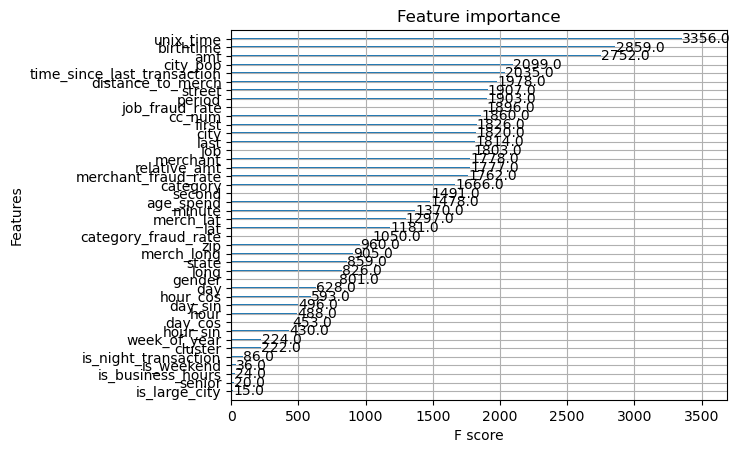

In [8]:
xgb_test_pred = xgb_model.predict(dtest)
print('xgb accuracy:', f1_score(Y_test, (xgb_test_pred >= 0.5).astype(int)))

xgb.plot_importance(xgb_model)
xgb_model.get_score()

# Predicting test.csv and creating Submission

In [9]:
sub_probs = xgb_model.predict(dsub)
print(len(sub_probs))
sub_pred = (sub_probs >= 0.5).astype(int)
print(len(sub_pred))

test['is_fraud'] = sub_pred
submission = test[['id', 'is_fraud']]
submission.to_csv("./submission.csv", index=False)

92676
92676
